In [1]:
%load_ext autoreload
%autoreload 2

## Initial Code Setup

In [2]:
#Import Packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

import os

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#Import custom classes
from Source.NN_model_2 import QNetwork
from Source.dqn_agent_2 import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.Env_Manager import EnvManager
from Source.Misc import plot

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
from datetime import date

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 60             #minibatch size
GAMMA = 0.999                #discount factor
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
SEED = 0                    #random seed number

TAU = 1e-3                  #for soft update of target parameters
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9984 #125e-6
EPISODE_STEP_LIMIT = 50
TRAIN_EPISODES = 3000
TEST_EPISODES = 20

#Choose the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def Initialize_Setup():
    #Choose the environment
    em = EnvManager(device, 'uav-v3', SEED)
    available_actions = em.num_actions_available()
    random.seed(SEED)

    #Select the strategy
    strategy = EpsilonGreedyStrategy(EPS_START, EPS_END, EPS_DECAY)

    #Initialize the agent
    agent = Agent(strategy, available_actions, SEED, device)

    #Instantiate MemoryBuffer
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, SEED, device)

    policy_net = QNetwork(available_actions, SEED).to(device)
    target_net = QNetwork(available_actions, SEED).to(device)
    #print(policy_net)

    #Initialize target_net weights to policy_net weights
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval() #Set the target_net in eval mode

    #Select the optimizer
    optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)
    return em, strategy, agent, memory, policy_net, target_net, optimizer

em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
measure = 'rate_thr_path'

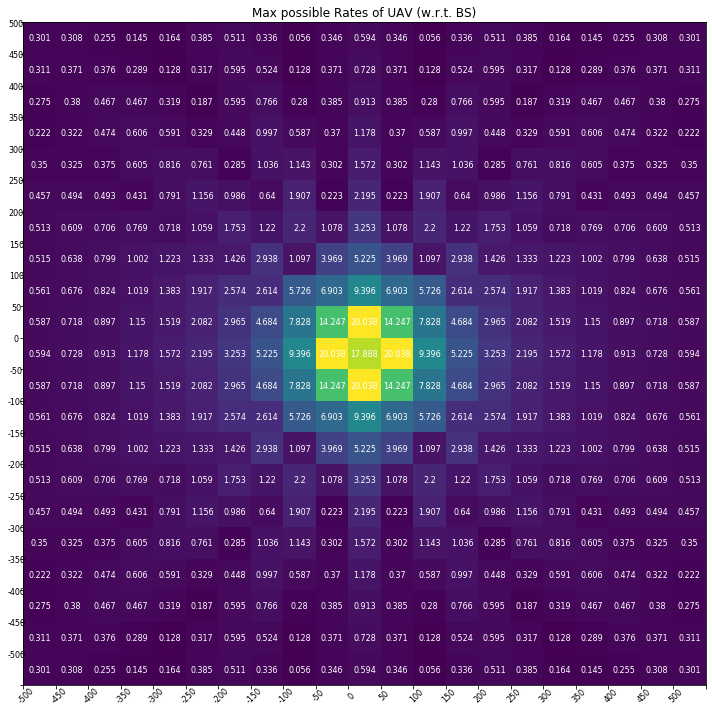

In [4]:
exh_rates_fname = 'env_exh_rates.txt'
ue_xloc = em.env.ue_xloc  #20 locs
ue_yloc = em.env.ue_yloc[::-1]     #20 locs

if os.path.exists(exh_rates_fname):
    rate_arr = np.loadtxt(exh_rates_fname, dtype=float)
else:
    # File is empty
    rate_tr = 0.0
    t_step = 0

    rate_arr = np.zeros([(max(ue_yloc)-min(ue_yloc))//50 +1, (max(ue_xloc)-min(ue_xloc))//50 + 1]) #(-500,50) -----> (500,500)
    for y_ndx in range(len(ue_yloc)):
        for x_ndx in range(len(ue_xloc)):
            state = np.array([ue_xloc[x_ndx], ue_yloc[y_ndx]])/ em.env.high_obs
            exh_bdir,exh_rate = em.env.get_Exh_Rate(state)
            rate_arr[y_ndx,x_ndx] = np.around(exh_rate, decimals=3)
    np.savetxt(exh_rates_fname, rate_arr, fmt='%f')

row_labels = [str(x) for x in ue_yloc]
col_labels = [str(x) for x in ue_xloc]

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(rate_arr, aspect='auto')

# We want to show all ticks...
ax.set_xticks(np.arange(rate_arr.shape[1]+1)-.5)
ax.set_yticks(np.arange(rate_arr.shape[0]+1)-.5)
# ... and label them with the respective list entries
ax.set_xticklabels(col_labels, fontsize=8)
ax.set_yticklabels(row_labels, fontsize=8)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="center",
         rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(rate_arr.shape[0]):
    for j in range(rate_arr.shape[1]):
        text = ax.text(j, i, rate_arr[i, j],
                       ha="center", va="center", color="w", fontsize=8)

ax.set_title("Max possible Rates of UAV (w.r.t. BS)")
fig.tight_layout()
plt.show()    



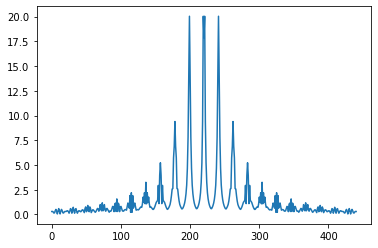

In [5]:
rate_arr = rate_arr.flatten()

plt.plot(rate_arr)
plt.show()

In [6]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [7]:
def Training_Loop(policy_net, target_net, memory, em, agent, optimizer, train_episodes, rate_thr, rate_ndx, measure):
    episode_durations = []
    episode_rewards = []
    policy_net.train()

    outer = tqdm.tqdm_notebook(total=train_episodes, desc='rate_thr: {0}-training loop: '.format(rate_ndx), position=0)

    for episode in range(train_episodes):
        #Set the rate requirement and reset environment
        state_indices = em.env.obs_space.sample()
        state = em.reset(rate_thr, measure, state_indices)
        
        ep_loss, ep_rwd, timestep = 0.0, 0.0, 0

        #Count the steps in agent
        agent.current_step +=1
        for timestep in count():
            action = agent.act(state, policy_net)
            next_state, reward, done, _ = em.step(action)
            ep_rwd += reward.item()
            memory.add(state, action, reward, next_state, done)

            state = next_state

            if memory.can_provide_sample():
                experiences = memory.sample()
                states, actions, rewards, next_states, dones = experiences

                current_q_values = policy_net(states).gather(1,index=actions.unsqueeze(-1))
                next_q_values = target_net(next_states).detach().max(1)[0]
                target_q_values = (next_q_values*GAMMA) + rewards

                loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
                ep_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (timestep==EPISODE_STEP_LIMIT) or done:
                episode_durations.append(timestep)
                episode_rewards.append(ep_rwd)
                print('\rEpisode {}\t timestep: {}, Score: {:.2f}, eps: {}'.format(episode+1, timestep, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step)), end="\r")
                break

        if episode % UPDATE_EVERY == 0:
            target_net.load_state_dict(policy_net.state_dict())
            
        # update tqdm outer progress bar
        outer.update(1)
    torch.save(policy_net.state_dict(), 'model_{0}_{1}_{2}.pth'.format(measure, date.today().strftime("%d%m%y"), rate_ndx))
    return episode_rewards, episode_durations

## 1. Training over different rate threshold

rate_threshold:  0.28
QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 3000	 timestep: 28, Score: 14.53, eps: 0.010014873609639282



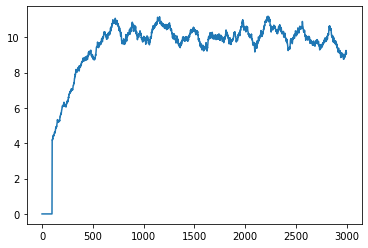

rate_threshold:  1.156
QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 3000	 timestep: 15, Score: 3.08, eps: 0.0110148736096392825



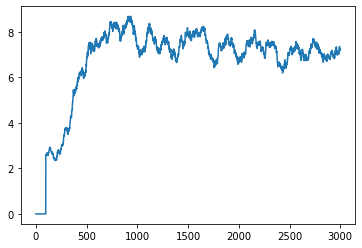

rate_threshold:  5.726
QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 3000	 timestep: 31, Score: 10.80, eps: 0.010148736096392829



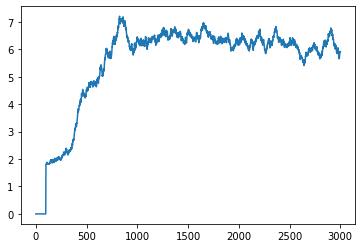

In [8]:
rate_thr_indices = [50, 120, 180]
rate_thr_rwd_fname = 'rate_thr_rewards.txt'
rate_thr_dur_fname = 'rate_thr_durations.txt'
measure = 'rate_thr_path'

rate_thr_episode_rewards = []
rate_thr_episode_durations = []
for rate_ndx in rate_thr_indices:
    print("rate_threshold: ", rate_arr[rate_ndx])
    
    #Re-Initialize Setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
    rate_thr = rate_arr[rate_ndx]
    
    #Training Loop
    episode_rewards, episode_durations = Training_Loop(policy_net, target_net, memory,em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
    
    print("\n")
    rate_thr_episode_rewards.append(episode_rewards)
    rate_thr_episode_durations.append(episode_durations)
    moving_avg = get_moving_average(100, episode_rewards)
    plt.plot(moving_avg)
    plt.show()

np.savetxt(rate_thr_rwd_fname, np.array(rate_thr_episode_rewards), fmt='%f')
np.savetxt(rate_thr_dur_fname, np.array(rate_thr_episode_durations), fmt='%f')



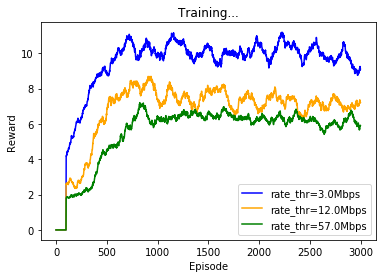

In [9]:
#Plot the figures
plt.figure()
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[0])
plt.plot(moving_avg0, color='blue', label='rate_thr={0}Mbps'.format(np.around(10*rate_arr[rate_thr_indices[0]]), decimals=2))

moving_avg1 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[1])
plt.plot(moving_avg1, color='orange', label='rate_thr={0}Mbps'.format(np.around(10*rate_arr[rate_thr_indices[1]]), decimals=2))


moving_avg2 = get_moving_average(moving_avg_period, rate_thr_episode_rewards[2])
plt.plot(moving_avg2, color='green', label='rate_thr={0}Mbps'.format(np.around(10*rate_arr[rate_thr_indices[2]]), decimals=2))    

plt.legend()
plt.show()

## 2. Path plot rate_threshold vs shortest path vs rate path

In [10]:
#rate_threshold path
rate_ndx = 120 #3 Mbps
#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_thr_path'
#Training Loop
rate_thr_episode_rewards, rate_thr_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
rate_thr_path_rates = em.env.ue_path_rates
rate_thr_path = em.env.ue_path_rates
#-------------------------------------------------------------------------------------------------------------------------------
#shortest path

#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'short_path'
#Training Loop
short_episode_rewards, short_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
short_path_rates = em.env.ue_path_rates
short_path = em.env.ue_path_rates

#------------------------------------------------------------------------------------------------------------------------------
#Rate Path

#Re-Initialize Setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
rate_thr = rate_arr[rate_ndx]
measure = 'rate_path'

#Training Loop
rate_episode_rewards, rate_episode_durations = Training_Loop(policy_net, target_net, memory, em, agent, optimizer, TRAIN_EPISODES, rate_thr, rate_ndx, measure)
print("\n")
rate_path_rates = em.env.ue_path_rates
rate_path = em.env.ue_path_rates

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 3000	 timestep: 29, Score: 12.59, eps: 0.010014873609639282

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 3000	 timestep: 16, Score: 4.20, eps: 0.010014873609639282

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=32, bias=True)
)


Episode 3000	 timestep: 18, Score: 9.19, eps: 0.0110014873609639282



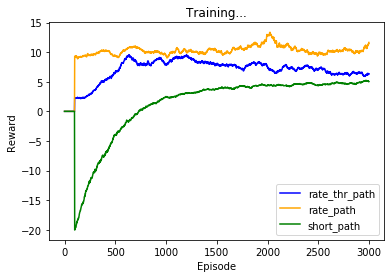

In [11]:
#Plot the figures
plt.figure()
plt.clf()
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
moving_avg_period = 100

moving_avg0 = get_moving_average(moving_avg_period, rate_thr_episode_rewards)
plt.plot(moving_avg0, color='blue', label='rate_thr_path')

moving_avg1 = get_moving_average(moving_avg_period, rate_episode_rewards)
plt.plot(moving_avg1, color='orange', label='rate_path')


moving_avg2 = get_moving_average(moving_avg_period, short_episode_rewards)
plt.plot(moving_avg2, color='green', label='short_path')    

plt.legend()
plt.show()

In [34]:
measures=['rate_thr_path', 'rate_path', 'short_path']
rate_ndx = 120

#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()
src_xndx, src_yndx = em.env.obs_space.sample()

src_loc = np.array([em.env.ue_xloc[src_xndx],em.env.ue_yloc[src_yndx]])
dest_loc = np.array([em.env.ue_xdest[0], em.env.ue_ydest[0]])
gNB_loc = np.array([em.env.gNB[0][0], em.env.gNB[0][1]]) #2D location
ue_paths = []
ue_path_rates=[]
ue_path_exh_rates = []
for meas in measures:
    
    #Initialize the setup
    em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()

    #Load the weights from file
    policy_net.load_state_dict(torch.load('model_{0}_{1}_{2}.pth'.format(meas, date.today().strftime("%d%m%y"), rate_ndx)))
    
    policy_net.eval()
    
    state_tensor = em.reset(rate_thr, meas, (src_xndx, src_yndx))
    
    exh_rates = []
    for t_step in count():
        action = policy_net(state_tensor).argmax(dim=1).to(device)
        next_state_tensor, reward, done, _ = em.step(action)
        
        state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
        #print("Current State: ", state)
        #print("Next State: ", next_state)
        
        curr_loc = (state[0], state[1])
        next_loc = (next_state[0], next_state[1])
        
        next_state = next_state / em.env.high_obs
        state = state / em.env.high_obs
        
        state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
        _, exh_rate = em.env.get_Exh_Rate(next_state)
        
        exh_rates.append(exh_rate)
        if (t_step == EPISODE_STEP_LIMIT) or done:
            break
    ue_paths.append(em.env.ue_path)
    ue_path_rates.append(em.env.ue_path_rates)
    ue_path_exh_rates.append(exh_rates)
#print(ue_paths)

rate thr Count: 34, short path count: 34


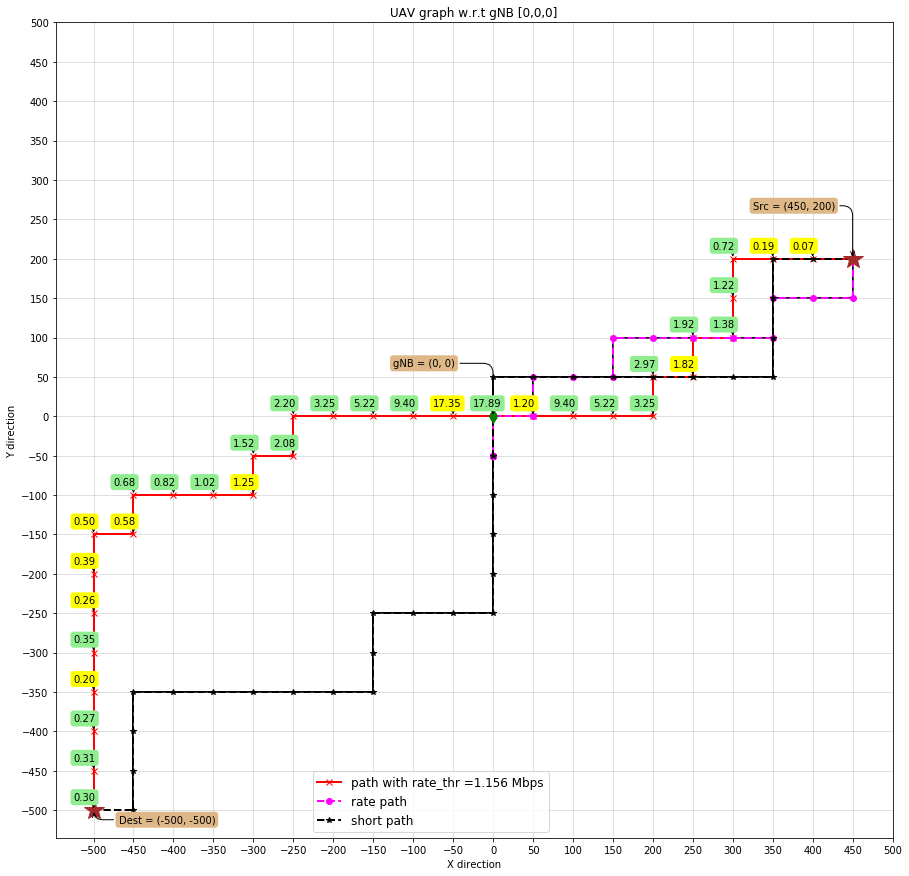

In [35]:
from matplotlib.path import Path
import matplotlib.patches as patches

#rate_thr_path
rate_thr_path = ue_paths[0]
rate_thr_path_rates = ue_path_rates[0]
rate_thr_path_exh_rates = ue_path_exh_rates[0]
rate_thr_verts = [(int(x[0]), int(x[1])) for x in rate_thr_path]
rate_thr_codes = [Path.LINETO for x in range(len(rate_thr_verts))]
rate_thr_codes[0] = Path.MOVETO
rate_thr_codes[-1] = Path.STOP
rate_thr_path  = Path(rate_thr_verts, rate_thr_codes)

#rate_path
rate_path = ue_paths[1]
rate_path_rates = ue_path_rates[1]
rate_verts = [(int(x[0]), int(x[1])) for x in rate_path]
rate_codes = [Path.LINETO for x in range(len(rate_verts))]
rate_codes[0] = Path.MOVETO
rate_codes[-1] = Path.STOP
rate_path  = Path(rate_verts, rate_codes)

#short_path
short_path = ue_paths[2]
short_path_rates = ue_path_rates[2]
short_verts = [(int(x[0]), int(x[1])) for x in short_path]
short_codes = [Path.LINETO for x in range(len(short_verts))]
short_codes[0] = Path.MOVETO
short_codes[-1] = Path.STOP
short_path  = Path(short_verts, short_codes)

print("rate thr Count: {}, short path count: {}".format(len(rate_thr_path), len(short_path)))
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
rate_thr_patch = patches.PathPatch(rate_thr_path, facecolor='none', lw=2)
rate_patch = patches.PathPatch(rate_path, facecolor='none', lw=2)
short_patch = patches.PathPatch(short_path, facecolor='none', lw=2)
ax.add_patch(rate_thr_patch)
ax.add_patch(rate_patch)
ax.add_patch(short_patch)

rate_thr_xs, rate_thr_ys = zip(*rate_thr_verts)
ax.plot(rate_thr_xs, rate_thr_ys, 'x-', lw=2, color='red', label='path with rate_thr ={} Mbps'.format(rate_arr[rate_ndx]))

rate_xs, rate_ys = zip(*rate_verts)
ax.plot(rate_xs, rate_ys, 'o--', lw=2, color='magenta', label='rate path')

short_xs, short_ys = zip(*short_verts)
ax.plot(short_xs, short_ys, '*--', lw=2, color='black', label='short path')

bbox = dict(boxstyle="round", facecolor='burlywood', edgecolor='none')
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="angle,angleA=0,angleB=90,rad=10")

offset = 50
#Plot src
ax.plot(src_loc[0], src_loc[1], marker='*',markersize=20, color='brown')
ax.annotate('Src = (%d, %d)' % (src_loc[0], src_loc[1]),
            (src_loc[0], src_loc[1]), xytext=(-2 * offset, offset), textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops)

ax.plot(dest_loc[0], dest_loc[1], marker='*',markersize=20, color='brown')
ax.annotate('Dest = (%d, %d)' % (dest_loc[0], dest_loc[1]),
                   (dest_loc[0], dest_loc[1]), xytext=(0.5 * offset, -0.25*offset),
                   textcoords='offset points',
                   bbox=bbox, arrowprops=arrowprops)

#Plot gNB
ax.plot(gNB_loc[0], gNB_loc[1], marker='d', markersize=10, color='green')
ax.annotate('gNB = (%d, %d)' % (gNB_loc[0], gNB_loc[1]),
                   (gNB_loc[0], gNB_loc[1]), xytext=(-2 * offset, offset),
                   textcoords='offset points',
                   bbox=bbox, arrowprops=arrowprops)

#Annotate rate values on proposed path 
offset= 10
bbox1 =dict(boxstyle="round", facecolor='yellow', edgecolor='none')
bbox2 =dict(boxstyle="round", facecolor='lightgreen', edgecolor='none') 
for i in range(0,len(rate_thr_path_rates)):
    if (np.around(rate_thr_path_rates[i], decimals=2) == np.around(rate_thr_path_exh_rates[i], decimals=2)):
        ax.annotate('{0:.2f}'.format(np.around(rate_thr_path_rates[i], decimals=2)) ,
                (rate_thr_verts[i+1][0], rate_thr_verts[i+1][1]), xytext=(-2 * offset, offset), textcoords='offset points',
                bbox=bbox2, arrowprops=arrowprops)
    else:
        ax.annotate('{0:.2f}'.format(np.around(rate_thr_path_rates[i], decimals=2)) ,
                (rate_thr_verts[i+1][0], rate_thr_verts[i+1][1]), xytext=(-2 * offset, offset), textcoords='offset points',
                bbox=bbox1, arrowprops=arrowprops)

ax.grid(alpha=0.5)
ax.set_xticks(em.env.ue_xloc)
ax.set_yticks(em.env.ue_yloc)
ax.set_title("UAV graph w.r.t gNB [0,0,0]")
ax.set_xlabel("X direction")
ax.set_ylabel("Y direction")
ax.legend(loc='best', bbox_to_anchor=(0.3, 0, .5, .5), fontsize='large')
plt.show()


## 3. No. of steps done vs rate threshold (between same source and destination)

In [41]:
measures=['rate_thr_path', 'short_path']

TEST_EPISODES = 20

#Initialize the setup
em, strategy, agent, memory, policy_net, target_net, optimizer = Initialize_Setup()  

models =['model_rate_thr_path_041019_50.pth', 'model_rate_thr_path_041019_120.pth', 'model_rate_thr_path_041019_180.pth', 'model_short_path_041019_120.pth']

model_ep_tsteps = []
model_ep_ue_paths=[]
model_ep_ue_path_rates = []
model_ep_ue_exh_rates = []
#get the 3 models with rate_thr approach, get the model with short_path_approach
#.... compare the number of steps over different episodes
state_indices_list = []
for episode in range(TEST_EPISODES):
    state_indices = em.env.obs_space.sample()
    state_indices_list.append(state_indices)
print(state_indices_list)

for model in models:
    #Load the weights from file
    print('Loading {} ...'.format(model))
    policy_net.load_state_dict(torch.load(model))
    policy_net.eval()

    #identify measure id and rate_thr
    meas_id = model.split('_')[1]
    rate_thr = rate_arr[int(model.split('_')[-1].split('.')[0])]
    
    model_tsteps=[]
    model_ue_paths =[]
    model_ue_path_rates =[]
    model_ue_exh_rates = []
    for state_indices in state_indices_list:
    
        #Env Reset based on measure id
        if(meas_id =='short'):
            state_tensor = em.reset(rate_thr, 'short_path', state_indices)
        else:
            state_tensor = em.reset(rate_thr, 'rate_thr_path', state_indices)
        
        step_count = 0
        exh_rates = []
        #Run Episode with the model
        for t_step in count():
            action = policy_net(state_tensor).argmax(dim=1).to(device)
            next_state_tensor, reward, done, _ = em.step(action)
            
            state = np.rint(state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            next_state = np.rint(next_state_tensor.squeeze().cpu().data.numpy() * em.env.high_obs)
            
            curr_loc = (state[0], state[1])
            next_loc = (next_state[0], next_state[1])
            
            next_state = next_state / em.env.high_obs
            state = state / em.env.high_obs
            state_tensor = torch.tensor(np.array([next_state]), dtype=torch.float32).to(device)
            
            step_count+=1
            _,exh_rate = em.env.get_Exh_Rate(next_state)
            
            exh_rates.append(exh_rate)
            if (t_step == EPISODE_STEP_LIMIT) or done:
                model_tsteps.append(step_count)
                print("rate_thr: {}, measure id: {}, count: {}".format(rate_thr, meas_id, step_count))
                model_ue_paths.append(em.env.ue_path)
                model_ue_path_rates.append(em.env.ue_path_rates)
                model_ue_exh_rates.append(exh_rates)
                break
    
    #Collect ep tsteps of each model
    model_ep_tsteps.append(model_tsteps)
    model_ep_ue_paths.append(model_ue_paths)
    model_ep_ue_path_rates.append(model_ue_path_rates)
    model_ep_ue_exh_rates.append(model_ue_exh_rates)
    
    print("\n\n")
    


[array([ 0, 10], dtype=int64), array([16,  0], dtype=int64), array([12,  6], dtype=int64), array([19,  0], dtype=int64), array([0, 4], dtype=int64), array([19,  7], dtype=int64), array([9, 6], dtype=int64), array([ 7, 11], dtype=int64), array([ 0, 19], dtype=int64), array([ 1, 12], dtype=int64), array([ 9, 17], dtype=int64), array([17,  7], dtype=int64), array([4, 0], dtype=int64), array([1, 2], dtype=int64), array([16,  2], dtype=int64), array([20,  0], dtype=int64), array([ 8, 16], dtype=int64), array([8, 3], dtype=int64), array([18,  3], dtype=int64), array([8, 7], dtype=int64)]
Loading model_rate_thr_path_041019_50.pth ...
rate_thr: 0.28, measure id: rate, count: 10
rate_thr: 0.28, measure id: rate, count: 16
rate_thr: 0.28, measure id: rate, count: 18
rate_thr: 0.28, measure id: rate, count: 21
rate_thr: 0.28, measure id: rate, count: 4
rate_thr: 0.28, measure id: rate, count: 26
rate_thr: 0.28, measure id: rate, count: 15
rate_thr: 0.28, measure id: rate, count: 18
rate_thr: 0.28

[array([ 300, -500]), array([ 250., -500.]), array([ 200., -500.]), array([ 150., -500.]), array([ 100., -500.]), array([  50., -500.]), array([   0., -500.]), array([ -50., -500.]), array([-100., -500.]), array([-150., -500.]), array([-200., -500.]), array([-250., -500.]), array([-300., -500.]), array([-350., -500.]), array([-400., -500.]), array([-450., -500.]), array([-500., -500.])]
[array([ 300, -500]), array([ 250., -500.]), array([ 200., -500.]), array([ 150., -500.]), array([ 100., -500.]), array([  50., -500.]), array([   0., -500.]), array([ -50., -500.]), array([-100., -500.]), array([-150., -500.]), array([-200., -500.]), array([-250., -500.]), array([-300., -500.]), array([-350., -500.]), array([-400., -500.]), array([-450., -500.]), array([-500., -500.])]


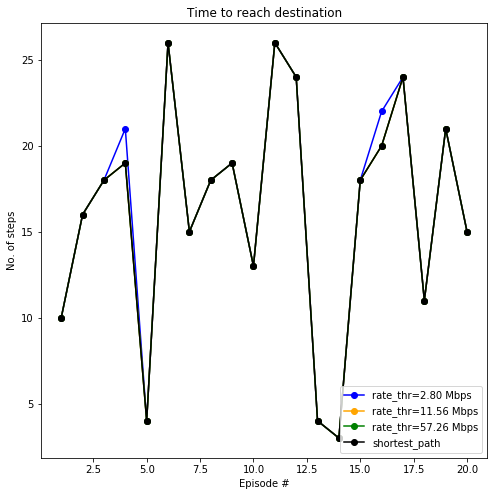

In [51]:
print(model_ep_ue_paths[0][1])
print(model_ep_ue_paths[1][1])
#print(model_ep_ue_path_rates[0][0])
#print(model_ep_ue_path_rates[1][0])
#print(model_ep_tsteps)
#Plot the graph in the end
x_axis = list(np.arange(1, TEST_EPISODES+1))
fig = plt.figure(figsize=(8,8))
plt.plot(x_axis, model_ep_tsteps[0], 'o-', color='blue', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[50]))

plt.plot(x_axis, model_ep_tsteps[1], 'o-', color='orange', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[120]))

plt.plot(x_axis, model_ep_tsteps[2], 'o-', color='green', label='rate_thr={:.2f} Mbps'.format(10*rate_arr[180]))

plt.plot(x_axis, model_ep_tsteps[3], 'o-', color='black', label='shortest_path')

plt.title('Time to reach destination')
plt.xlabel('Episode #')
plt.ylabel('No. of steps')
plt.legend()
plt.show()


## 4. Performance Score vs rate threshold, Efficiceny score vs rate threshold (over episode #)

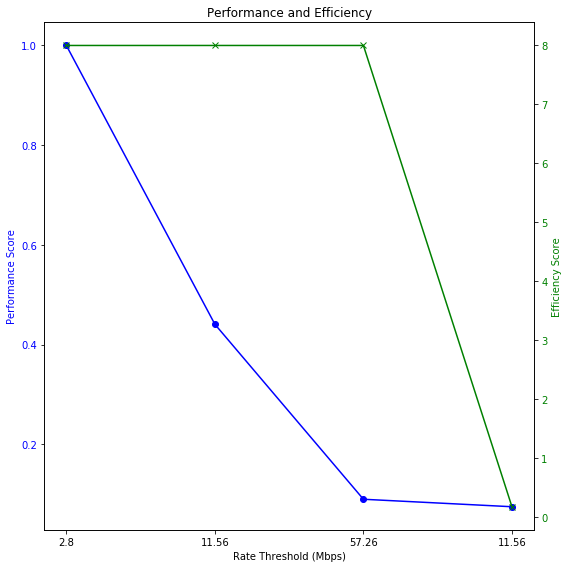

In [67]:
rate_thr_indices = [50,120,180,120]


model_perf_scores = []
model_eff_scores = []
for model_ndx in range(len(model_ep_ue_path_rates)):
    ep_perf_scores = []
    ep_eff_scores = []
    for ep_ndx in range(len(model_ep_ue_path_rates[model_ndx])):
        model_score, exh_score = 0,0
        perf_score = 0.0
        eff_score = 0.0
        for rate_ndx in range(len(model_ep_ue_path_rates[model_ndx][ep_ndx])):
            if model_ep_ue_path_rates[model_ndx][ep_ndx][rate_ndx] >= rate_arr[rate_thr_indices[model_ndx]]:
                model_score += 1
            if model_ep_ue_exh_rates[model_ndx][ep_ndx][rate_ndx] >= rate_arr[rate_thr_indices[model_ndx]]:
                exh_score += 1
            #Compute Efficiency Score
            if (model_ep_ue_exh_rates[model_ndx][ep_ndx][rate_ndx] != 0):
                eff_score = model_ep_ue_path_rates[model_ndx][ep_ndx][rate_ndx]/(model_ep_ue_exh_rates[model_ndx][ep_ndx][rate_ndx]/em.env.N_rx)
        #Compute performance score
        if exh_score > 0:
            perf_score = float(model_score)/float(exh_score)
        ep_perf_scores.append(perf_score)
        ep_eff_scores.append(eff_score)
        
        
    model_perf_scores.append(ep_perf_scores)
    model_eff_scores.append(ep_eff_scores)
    

x_axis = list(np.arange(1, len(rate_thr_indices)+1))
model_mean_perf_scores = [np.mean(x) for x in model_perf_scores]
model_mean_eff_scores = [np.mean(x) for x in model_eff_scores]

#fig = plt.figure(figsize=(8,8))

fig, ax1 = plt.subplots(figsize=(8,8))
ax1.set_title('Performance and Efficiency')
ax1.set_xlabel('Rate Threshold (Mbps)')
ax1.set_ylabel('Performance Score', color='blue')
ax1.plot(x_axis, model_mean_perf_scores, 'o-', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Efficiency Score', color='green')  # we already handled the x-label with ax1
ax2.plot(x_axis, model_mean_eff_scores, 'x-', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.xticks(np.array(x_axis), [str(np.around(10*rate_arr[x], decimals=2)) for x in rate_thr_indices])
plt.show()
